In [ ]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import psycopg2
import calendar

In [ ]:
conn = psycopg2.connect(
    host='shopify-merchant-dump.ccm9mnr5avgs.ap-south-1.rds.amazonaws.com',
    port='5432',
    user='paakhi_b014108f50994e35ab8fa4e2dc26d612',
    password='paakhi_b014108f50994e35ab8fa4e2dc26d612_password',
    database='paakhi_b014108f50994e35ab8fa4e2dc26d612_db'
)

In [ ]:
query1 = """select orders.id as order_id,
created_at::date as order_date,
customer_id as user_id,
order_line_item.product_id as product_id,
order_line_item.name as product_name,
order_line_item.quantity as quantity,
(order_line_item.price - order_line_item.total_discount) as sp
from orders
join order_line_item on orders.id  = order_line_item.order_id
where cancelled_at is NULL;"""

In [ ]:
data = pd.read_sql(query1, conn)

<ipython-input-4-0600e2216395>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query1, conn)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061 entries, 0 to 1060
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   order_id      1061 non-null   int64  
 1   order_date    1061 non-null   object 
 2   user_id       1061 non-null   int64  
 3   product_id    1042 non-null   float64
 4   product_name  1061 non-null   object 
 5   quantity      1061 non-null   int64  
 6   sp            1061 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 58.1+ KB


In [ ]:
data.order_date

0       2023-11-25
1       2023-11-25
2       2023-11-25
3       2023-11-25
4       2023-11-25
           ...    
1056    2023-11-26
1057    2023-11-26
1058    2023-11-26
1059    2023-11-26
1060    2023-11-26
Name: order_date, Length: 1061, dtype: object

In [ ]:
data

,order_id,order_date,user_id,product_id,product_name,quantity,sp
0,5404755329281,2023-11-25,7082971169025,8.062692e+12,Fitted sheet with pillow covers - White - King,2,1200.0
1,5404755329281,2023-11-25,7082971169025,8.062627e+12,Organic Cotton Throw - Mustard,3,650.0
2,5404697428225,2023-11-25,7006184505601,8.062714e+12,Autumn Flowers Handblock Printed Cotton Bedshe...,1,3300.0
3,5404697428225,2023-11-25,7006184505601,8.062713e+12,Canela Handblock Printed Cotton Bedsheet - King,1,3300.0
4,5404697428225,2023-11-25,7006184505601,8.062673e+12,Mint Flower Bunch - Super King Bedsheet And Pi...,1,2800.0
...,...,...,...,...,...,...,...
1056,5406566711553,2023-11-26,7084887310593,8.106696e+12,Hand Block quilt - Indigo - King,1,6100.0
1057,5406528241921,2023-11-26,7084842778881,8.062688e+12,Fitted sheet with pillow covers - Light Grey -...,1,1200.0
1058,5406478303489,2023-11-26,7084772983041,8.074634e+12,Fitted sheet with pillow covers - Malt - King,1,1200.0
1059,5406277075201,2023-11-26,7067133051137,8.062710e+12,Montrose Biscuit - Mulmul Summer Katha,1,2800.0


In [ ]:
#New/Repeat Tag
orderuserlevel=data.groupby(['order_id','user_id']).agg(
          order_date=pd.NamedAgg(column='order_date', aggfunc='min'),

    ).reset_index()
orderuserlevel=orderuserlevel.sort_values('order_date')
orderuserlevel['TrxnRank'] = orderuserlevel.groupby('user_id')['order_date'].rank(method='first')
orderuserlevel


data=pd.merge(data,
         orderuserlevel[['order_id','TrxnRank']],
         on="order_id",
         how ='left')
data['New']=0
data['Repeat']=0
data.loc[data['TrxnRank']==1,'New']=1
data.loc[data['TrxnRank']>1,'Repeat']=1

#AOV Contribution
data['ordervalue']=data['quantity']*data['sp']
data['AOVContribution']=data['ordervalue']/data["order_id"].nunique()

In [ ]:
totalcarts=data['order_id'].nunique()
productlevel=data.groupby(['product_id','product_name']).agg(
          Carts=pd.NamedAgg(column='order_id', aggfunc='nunique'),
     Quantity=pd.NamedAgg(column='quantity', aggfunc='sum'),
          ASP=pd.NamedAgg(column='sp', aggfunc='mean'),
          NewOrders=pd.NamedAgg(column='New', aggfunc='sum'),
          RepeatOrders=pd.NamedAgg(column='Repeat', aggfunc='sum'),
          Users=pd.NamedAgg(column='user_id', aggfunc='nunique'),
          AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
    ).reset_index()
productlevel['CartPenetration']=productlevel['Carts']/totalcarts
productlevel['NewUserRatio']=productlevel['NewOrders']/productlevel['Users']
productlevel['QpC']=productlevel['Quantity']/productlevel['Carts']
productlevel['ASPXQpC']=productlevel['ASP']*productlevel['QpC']

In [ ]:
productlevel.sort_values('CartPenetration', ascending=False).head(50)

,product_id,product_name,Carts,Quantity,ASP,NewOrders,RepeatOrders,Users,AOVContribution,CartPenetration,NewUserRatio,QpC,ASPXQpC
49,8.062653e+12,Teal Floral - Bedsheet And Pillowcase Set,82,83,2300.000000,78,4,80,261.149111,0.112175,0.975000,1.012195,2328.048780
138,8.062683e+12,Red Tree of Life - Bedsheet And Pillowcase Set...,46,48,2567.391304,41,5,46,168.673051,0.062927,0.891304,1.043478,2679.017013
215,8.062701e+12,Madison Cream - Bedsheet & Quilted Pillow Cove...,23,24,2300.000000,20,3,23,75.512996,0.031464,0.869565,1.043478,2400.000000
61,8.062656e+12,Blue Tree of Life - Bedsheet And Pillowcase Se...,20,20,2435.000000,18,2,20,66.621067,0.027360,0.900000,1.000000,2435.000000
256,8.062712e+12,Crimson - Mulmul Summer Katha,18,18,2800.000000,15,3,17,68.946648,0.024624,0.882353,1.000000,2800.000000
220,8.062702e+12,Bird Valley Olive Green - Bedsheet & Quilted P...,16,16,2300.000000,16,0,16,50.341997,0.021888,1.000000,1.000000,2300.000000
224,8.062703e+12,Tea Green Floral - Bedsheet And Pillowcase Set,16,16,2300.000000,15,1,16,50.341997,0.021888,0.937500,1.000000,2300.000000
283,8.106696e+12,Hand Block quilt - Indigo - King,14,15,6100.000000,14,0,14,125.170999,0.019152,1.000000,1.071429,6535.714286
249,8.062710e+12,Montrose Biscuit - Mulmul Summer Katha,11,11,2800.000000,8,3,11,42.134063,0.015048,0.727273,1.000000,2800.000000
54,8.062654e+12,Yellow Floral - Bedsheet And Pillowcase Set - ...,11,11,2509.090909,9,2,11,37.756498,0.015048,0.818182,1.000000,2509.090909


In [ ]:

CP_labels, NewRatio_labels,ASP_labels, QpC_labels =  range(1,5), range(1,5),range(1,5),range(1,5)

productlevel['CP_score'] = productlevel['CartPenetration'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = CP_labels)).astype('int64')
productlevel['NewRatio_score'] = productlevel['NewUserRatio'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = NewRatio_labels)).astype('int64')
productlevel['ASP_score'] = productlevel['ASP'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = ASP_labels)).astype('int64')
productlevel['QpC_score'] = productlevel['QpC'].transform(lambda x: pd.qcut(x.rank(method='first'), q = [0, 0.25, 0.5, 0.75, 1], labels = QpC_labels)).astype('int64')
productlevel['SumScore'] = productlevel['CP_score'] + productlevel['NewRatio_score'] + productlevel['ASP_score'] + productlevel['QpC_score']


In [ ]:

def ProductCohortLables(df):
    if df['SumScore'] > 15:
        return 'Hero Products'
    elif ((df['CP_score'] >3) and (df['SumScore'] >= 8)and (df['SumScore'] <= 15) and (df['NewRatio_score'] >3)):
        return 'Marquee & New Business Drivers'
    elif ((df['CP_score'] >3) and (df['SumScore'] >= 8)and (df['SumScore'] <= 15)and (df['NewRatio_score'] <=3)):
        return 'Marquee & Repeat Business Drivers'

    elif ((df['ASP_score'] >3) and (df['SumScore'] >= 5)and (df['SumScore'] < 8)and (df['QpC_score'] <=3)):
        return 'High Value & Slow Moving'
    elif ((df['ASP_score'] <=3) and (df['SumScore'] >= 5)and (df['SumScore'] < 8)and (df['QpC_score'] >3)):
        return 'Low Value & Slow Moving'
    else:
        return 'Lagging Products'

In [ ]:
productlevel['Product Cohort Lables'] = productlevel.apply(ProductCohortLables, axis=1)


In [ ]:
productlevel['Product Cohort Lables'].value_counts()

Lagging Products                     212
Marquee & Repeat Business Drivers     58
Marquee & New Business Drivers        11
High Value & Slow Moving               4
Hero Products                          3
Name: Product Cohort Lables, dtype: int64

In [ ]:
productlevel

,product_id,product_name,Carts,Quantity,ASP,NewOrders,RepeatOrders,Users,AOVContribution,CartPenetration,NewUserRatio,QpC,ASPXQpC,CP_score,NewRatio_score,ASP_score,QpC_score,SumScore,Product Cohort Lables
0,8.062598e+12,Organic Cotton Throw – Brown - Default Title,2,2,850.0,2,0,2,2.325581,0.002736,1.0,1.000000,850.000000,2,2,1,1,6,Lagging Products
1,8.062604e+12,Hand Block Summer quilt - Purple Floral - Defa...,4,4,6200.0,4,0,4,33.926129,0.005472,1.0,1.000000,6200.000000,3,2,4,1,10,Lagging Products
2,8.062605e+12,Organic Cotton Throw - Mustard,3,5,800.0,3,0,3,5.471956,0.004104,1.0,1.666667,1333.333333,3,2,1,4,10,Lagging Products
3,8.062605e+12,Organic Cotton Throw - Mustard - Default Title,3,3,850.0,3,0,3,3.488372,0.004104,1.0,1.000000,850.000000,3,2,1,1,7,Lagging Products
4,8.062610e+12,Hand Block quilt - Inde - Default Title,1,1,5990.0,1,0,1,8.194254,0.001368,1.0,1.000000,5990.000000,1,2,4,1,8,Lagging Products
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,8.106696e+12,Hand Block quilt - Indigo - King,14,15,6100.0,14,0,14,125.170999,0.019152,1.0,1.071429,6535.714286,4,4,4,4,16,Hero Products
284,8.106697e+12,Hand Block quilt - Indigo Petals - King,2,2,6100.0,1,1,2,16.689466,0.002736,0.5,1.000000,6100.000000,3,1,4,4,12,Lagging Products
285,8.106711e+12,Hand Block Printed Quilt with Pillow Covers - ...,1,1,7400.0,0,1,1,10.123119,0.001368,0.0,1.000000,7400.000000,2,1,4,4,11,Lagging Products
286,8.106712e+12,Hand Block Printed Quilt with Pillow Covers - ...,1,1,7400.0,1,0,1,10.123119,0.001368,1.0,1.000000,7400.000000,2,4,4,4,14,Lagging Products


In [ ]:
segstats=productlevel.groupby(
   'Product Cohort Lables'
).agg(
       ProductCount=pd.NamedAgg(column='product_id', aggfunc='nunique'),
       Orders=pd.NamedAgg(column='Carts', aggfunc='sum'),
       Users=pd.NamedAgg(column='Users', aggfunc='sum'),
       AverageSellingPrice=pd.NamedAgg(column='ASP', aggfunc='mean'),
       QuantityperCart=pd.NamedAgg(column='QpC', aggfunc='mean'),
       CartPenetration  =pd.NamedAgg(column='CartPenetration', aggfunc='mean'),
       NewUserRatio=pd.NamedAgg(column='NewUserRatio', aggfunc='mean'),
      NewOrders=pd.NamedAgg(column='NewOrders', aggfunc='sum'),
       ASPXQpC=pd.NamedAgg(column='ASPXQpC', aggfunc='sum'),
       AOVContribution=pd.NamedAgg(column='AOVContribution', aggfunc='sum'),
       Top10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[:10]),
      Bottom10SKUs=pd.NamedAgg(column='product_name', aggfunc=lambda x: x.value_counts().index[-10:-1])

 ).reset_index()
segstats=segstats.sort_values('CartPenetration', ascending =False)
segstats
segstats['ProductCountMix']=segstats['ProductCount']/segstats['ProductCount'].sum()
segstats['OrdersMix']=segstats['Orders']/segstats['Orders'].sum()
segstats['UsersMix']=segstats['Users']/segstats['Users'].sum()
segstats['AOVContribution(%)']=segstats['AOVContribution']/segstats['AOVContribution'].sum()
segstats['OrderPerSKU']=segstats['Orders']/segstats['ProductCount']

In [ ]:
segstats.columns

Index(['Product Cohort Lables', 'ProductCount', 'Orders', 'Users',
       'AverageSellingPrice', 'QuantityperCart', 'CartPenetration',
       'NewUserRatio', 'NewOrders', 'ASPXQpC', 'AOVContribution', 'Top10SKUs',
       'Bottom10SKUs', 'ProductCountMix', 'OrdersMix', 'UsersMix',
       'AOVContribution(%)', 'OrderPerSKU'],
      dtype='object')

In [ ]:
SummaryTable=segstats[['Product Cohort Lables', 'ProductCount','OrdersMix',
       'UsersMix','AverageSellingPrice',
       'CartPenetration',"QuantityperCart",'NewUserRatio','AOVContribution',
       'Top10SKUs', 'Bottom10SKUs','OrderPerSKU', ]]


In [ ]:
SummaryTable.to_csv('st.csv')
#productlevel.to_csv('pl.csv')

In [ ]:
SummaryTable


,Product Cohort Lables,ProductCount,OrdersMix,UsersMix,AverageSellingPrice,CartPenetration,QuantityperCart,NewUserRatio,AOVContribution,Top10SKUs,Bottom10SKUs,OrderPerSKU
4,Marquee & Repeat Business Drivers,48,0.523992,0.521781,2365.360991,0.012878,1.025026,0.808339,1805.800274,[Jaipuri Razai - Sea Green Floral - Default Ti...,[Coral Floral - Bedsheet And Pillowcase Set - ...,11.375000
0,Hero Products,3,0.021113,0.021297,5633.333333,0.010032,1.107143,1.000000,191.655267,[Rome Red - Bedsheet & Summer Katha Set - Defa...,[Rome Red - Bedsheet & Summer Katha Set - Defa...,7.333333
3,Marquee & New Business Drivers,11,0.061420,0.060987,2745.454545,0.007959,1.059091,1.000000,233.652531,[Fitted sheet with pillow covers - TEAL - Defa...,[Set of 2 Solid White Kantha Pillow Covers - S...,5.818182
2,Lagging Products,160,0.389635,0.392062,4206.839623,0.002620,1.015330,0.834119,2229.110807,"[Organic Cotton Throw – Brown - Default Title,...",[Handblock Printed Towel - Floral Mesh - 1 Bat...,2.537500
1,High Value & Slow Moving,4,0.003839,0.003872,9775.000000,0.001368,1.000000,0.000000,53.488372,"[Jaipuri Razai - Forest Green Floral, Mandela ...","[Jaipuri Razai - Forest Green Floral, Mandela ...",1.000000


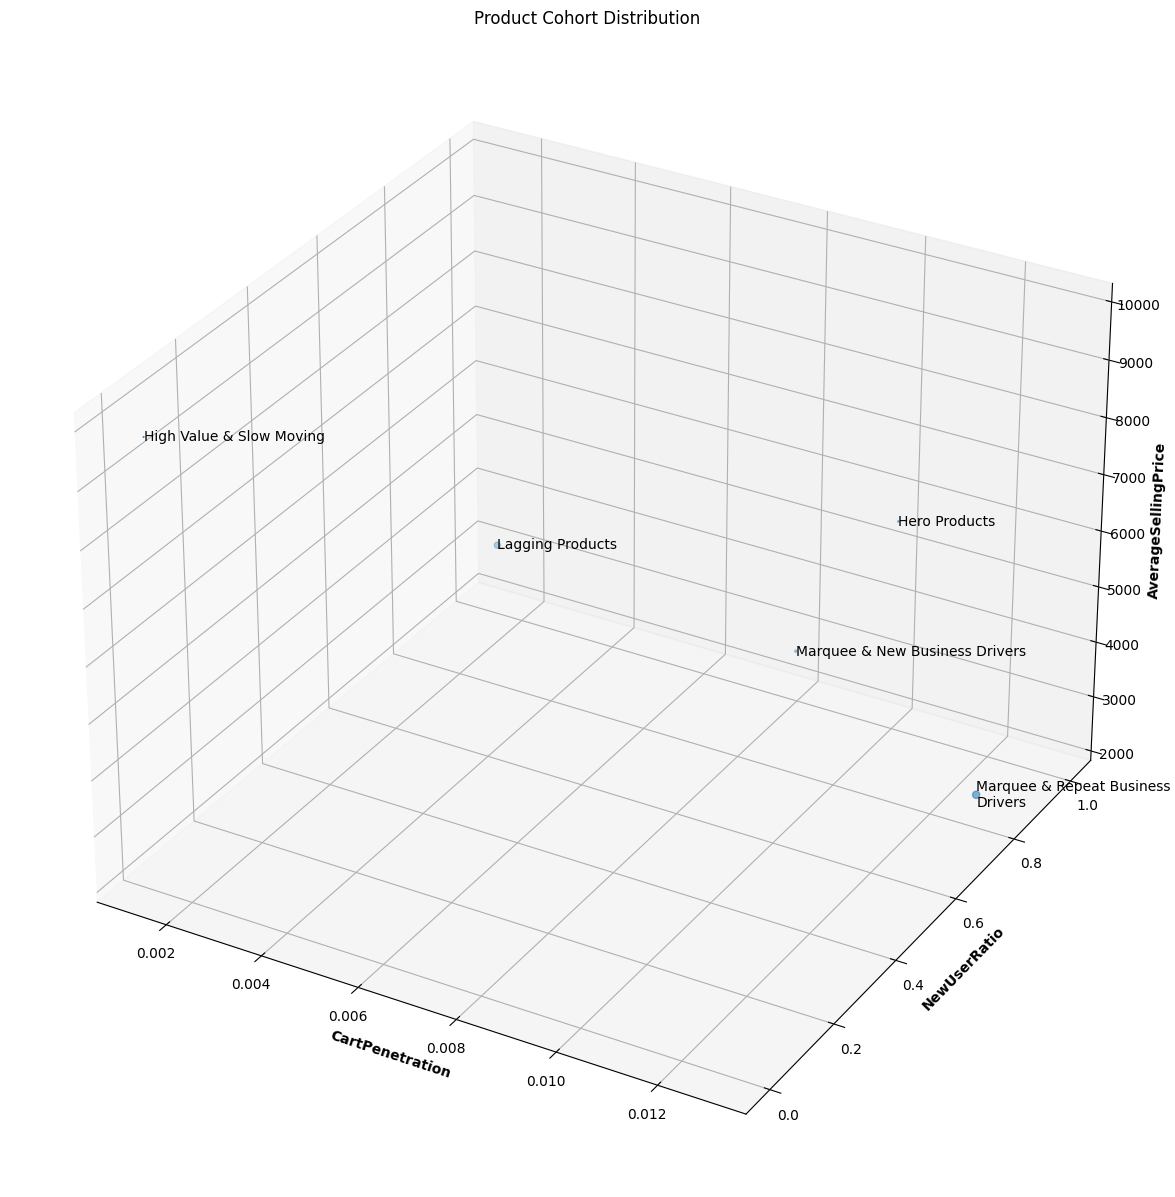

In [ ]:
#Visualization of cohorts with key parameters as axises
fig = plt.figure(figsize = (15, 15))
ax = plt.axes(projection ="3d")
size=segstats['Users']*.05
# Creating plot
ax.scatter3D(segstats['CartPenetration'], segstats['NewUserRatio'],segstats['AverageSellingPrice'], s=size)
plt.title("Product Cohort Distribution")
ax.set_xlabel('CartPenetration', fontweight ='bold')
ax.set_ylabel('NewUserRatio', fontweight ='bold')
ax.set_zlabel('AverageSellingPrice', fontweight ='bold')
for i in range(len(segstats)):
     ax.text(segstats['CartPenetration'][i],
               segstats['NewUserRatio'][i],
             segstats['AverageSellingPrice'][i],
               segstats['Product Cohort Lables'][i],
               horizontalalignment='left',
               rotation=25, wrap=True,
               verticalalignment='center',
               size='medium', color='black')
